# Common Constants

In [1]:
import os
CASE_COUNT = 95
META_COUNT = None # number of trials per
BUGS2FIX_PROMPT_INDEX = 1

BATTERY_DIR = "./data/CodeXGLUE/Code-Code/code-refinement/data/small"
BATTERY_SRC = os.path.join(BATTERY_DIR, "test.buggy-fixed.buggy")
TRUTH_SRC = os.path.join(BATTERY_DIR, "test.buggy-fixed.fixed")
OUTPUT_DIR = f"./output/bugs2fix/prompt{BUGS2FIX_PROMPT_INDEX}"

BUGS2FIX_PROMPTS = [
    "// the buggy version of the code\n{prompt}\n// the fixed version of the code\n",
    "// You are given a piece of buggy code. Your task is to fix the error, and generate the corrected code. Fix the following code:\n{prompt}\n",
]

BUGS2FIX_PROMPT = BUGS2FIX_PROMPTS[BUGS2FIX_PROMPT_INDEX]

In [2]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
BATTERY = []
with open(BATTERY_SRC, "r") as battery:
    BATTERY = [
        line.strip()
        for line
        in battery.readlines()[:CASE_COUNT]
    ]
print(f"Loaded {len(BATTERY)} cases!")

Loaded 95 cases!


In [3]:
from timehelp import with_progress, display_header
import time
import ipywidgets as widgets
from IPython.display import display

In [4]:
print("Importing torch...")
import torch
import torch.nn as nn
print("Importing HF...")
from transformers import AutoTokenizer, AutoModelForCausalLM
print("Importing python modules...")
from timehelp import time_start, time_end
from model_wrapper import Model, ModelFamily, MultipleChoiceStrategy
import re
print("Done!")

Importing torch...
Importing HF...
Importing python modules...
Done!


# Generate Output

In [5]:
Model.test_battery(
    family=ModelFamily.CodeGen1.multi,
    family_name="codegen1-multi",
    battery=BATTERY,
    prompt=BUGS2FIX_PROMPT,
    meta_count=META_COUNT,
    output_dir=OUTPUT_DIR,
)

HTML(value="<h1 style='font-weight: bold;'>Loading 350M (Salesforce/codegen-350M-multi)</h1>")

# Loading 350M (Salesforce/codegen-350M-multi)
[2024-05-21@07:59:05|model.device] Starting timer.
Configuring torch device...
Using device: cuda:0 aka cuda:0
[2024-05-21@07:59:05|model.device] Time elapsed: 63ms
[2024-05-21@07:59:05|model.tokenizer] Starting timer.
[2024-05-21@07:59:05|model.tokenizer] Time elapsed: 242ms
[2024-05-21@07:59:05|model.model] Starting timer.
Obtaining model...
[2024-05-21@07:59:08|model.model] Time elapsed: 3s 447ms


Done, ~0s elapsed.


HTML(value="<h1 style='font-weight: bold;'>Loading 2B (Salesforce/codegen-2B-multi)</h1>")

# Loading 2B (Salesforce/codegen-2B-multi)
[2024-05-21@07:59:09|model.device] Starting timer.
Configuring torch device...
Using device: cuda:0 aka cuda:0
[2024-05-21@07:59:09|model.device] Time elapsed: ~0s
[2024-05-21@07:59:09|model.tokenizer] Starting timer.
[2024-05-21@07:59:09|model.tokenizer] Time elapsed: 286ms
[2024-05-21@07:59:09|model.model] Starting timer.
Obtaining model...
[2024-05-21@07:59:18|model.model] Time elapsed: 8s 712ms


Done, ~0s elapsed.


HTML(value="<h1 style='font-weight: bold;'>Loading 6B (Salesforce/codegen-6B-multi)</h1>")

# Loading 6B (Salesforce/codegen-6B-multi)
[2024-05-21@07:59:18|model.device] Starting timer.
Configuring torch device...
Using device: cuda:0 aka cuda:0
[2024-05-21@07:59:18|model.device] Time elapsed: ~0s
[2024-05-21@07:59:18|model.tokenizer] Starting timer.
[2024-05-21@07:59:18|model.tokenizer] Time elapsed: 192ms
[2024-05-21@07:59:18|model.model] Starting timer.
Obtaining model...


[2024-05-21@07:59:38|model.model] Time elapsed: 19s 528ms


!! max size might be exceeded !!
inputs so far: // You are given a piece of buggy code. Your task is to fix the error, and generate the corrected code. Fix the following code:
public boolean METHOD_1 ( TYPE_1 VAR_1, java.util.Map < TYPE_2, java.util.List < TYPE_1 > > VAR_2, java.util.List < TYPE_3 > VAR_3, TYPE_4 VAR_4, boolean VAR_5 ) { return true ; }

public boolean METHOD_2 ( TYPE_1 VAR_1, TYPE_2 VAR_2, TYPE_3 VAR_3, TYPE_4 VAR_4, TYPE_5 VA [ ... 501 bytes abbreviated ... ] VAR_37, TYPE_38 VAR_38, TYPE_39 VAR_39, TYPE_40 VAR_40, TYPE_41 VAR_41, TYPE_42 VAR_42, TYPE_43 VAR_
!! max size might be exceeded !!
inputs so far: // You are given a piece of buggy code. Your task is to fix the error, and generate the corrected code. Fix the following code:
public void METHOD_1 ( java.lang.String url, TYPE_1 VAR_1, TYPE_2 VAR_2, TYPE_3 status ) { VAR_3. id ( VAR_1 ). METHOD_2 ( TYPE_4. METHOD_3 ( TYPE_4. METHOD_4 ( VAR_2 ) ) ). METHOD_5 ( VAR_4 ) ; }

public void METHOD_2 ( TYPE_5 VAR_1 ) { VA

HTML(value="<h1 style='font-weight: bold;'>Loading 16B (Salesforce/codegen-16B-multi)</h1>")

# Loading 16B (Salesforce/codegen-16B-multi)
[2024-05-21@08:51:13|model.device] Starting timer.
Configuring torch device...
Using device: cuda:0 aka cuda:0
[2024-05-21@08:51:13|model.device] Time elapsed: ~0s
[2024-05-21@08:51:13|model.tokenizer] Starting timer.
[2024-05-21@08:51:13|model.tokenizer] Time elapsed: 309ms
[2024-05-21@08:51:13|model.model] Starting timer.
Obtaining model...


[2024-05-21@08:54:27|model.model] Time elapsed: 3min 14s


!! max size might be exceeded !!
inputs so far: // You are given a piece of buggy code. Your task is to fix the error, and generate the corrected code. Fix the following code:
private static TYPE_1 METHOD_1 ( int n ) { TYPE_1 VAR_1 = VAR_2 ; for ( int i = n ; i > 1 ; i -- ) { VAR_1 = VAR_1. METHOD_2 ( new TYPE_1 ( java.lang.Integer.toString ( i ) ) ) ; } return VAR_1 ; }
private static TYPE_1 METHOD_2 ( TYPE_1 VAR_1 ) { TYPE_1 VAR_2 = VAR_1 ; f [ ... 535 bytes abbreviated ... ] 1 ). METHOD_1 ( 1 ). METHOD_1 ( 1 ). METHOD_1 ( 1 ). METHOD_1 ( 1 ). METHOD_1 ( 1 ). METHOD_1 ( 1 ).
Done, 8hr 52min 19s elapsed.


# Interpret Output

In [5]:
import matplotlib.pyplot as plt
from render_output import OutputRenderer

In [6]:
with open(TRUTH_SRC, "r") as truth_file:
    answer_key = truth_file.readlines()

prompt_family_answers = []
for prompt_index in range(len(BUGS2FIX_PROMPTS)):
    output_dir = f"./output/bugs2fix/prompt{prompt_index}"
    family_answers = {}
    for key, model_name in ModelFamily.CodeGen1.multi.items():
        output_path = os.path.join(output_dir, f"codegen1-multi-{key}.output")
        with open(output_path, "r") as output_file:
            answers = output_file.readlines()
        family_answers[key] = answers
    prompt_family_answers.append(family_answers)

## Metric: Accuracy (Exact Match)

In [7]:
accuracy_em_metric = {}

for idx, family_answers in enumerate(prompt_family_answers):
    metric_series = []
    for key, answers in family_answers.items():
        correct = 0
        for answer, truth in zip(answers, answer_key):
            if answer.strip() == truth.strip():
                correct += 1
        metric_series.append(correct)
    accuracy_em_metric[f"prompt{idx}"] = metric_series

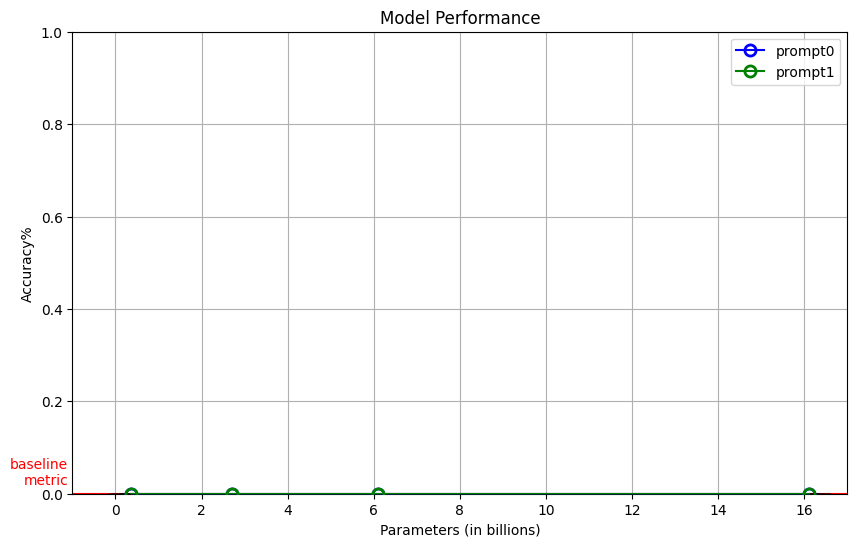

In [8]:
bugs2fix_renderer_em = OutputRenderer(
    baseline=0.0,
    metric="Accuracy%",
)

bugs2fix_renderer_em.render(ys=accuracy_em_metric)

## Metric: BLEU

In [9]:
from bleu import _bleu
bleu_metrics = {}
bleu_baseline = 0.0 # _bleu(answer_key[:len(BATTERY)], BATTERY)
for idx, family_answers in enumerate(prompt_family_answers):
    metric_series = []
    for key, answers in family_answers.items():
        metric_series.append(_bleu(answer_key[:len(answers)], answers))
    bleu_metrics[f"prompt{idx}"] = metric_series

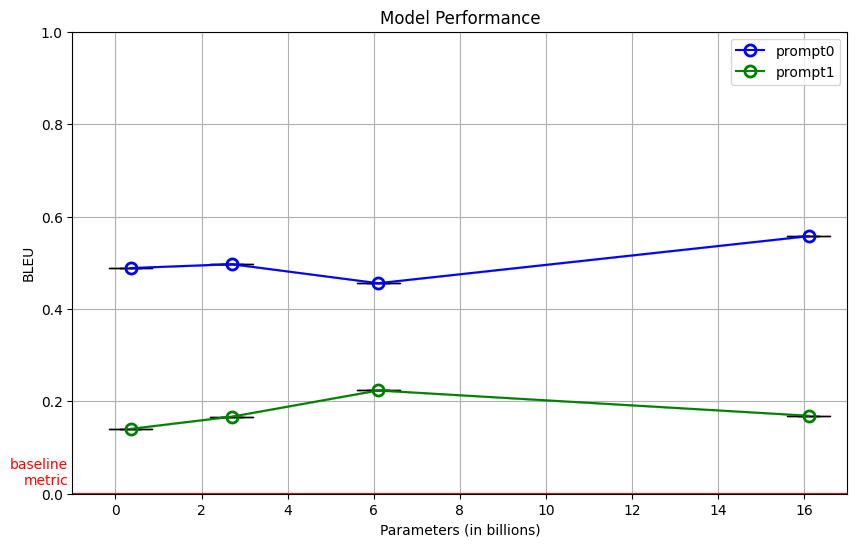

In [14]:
bugs2fix_renderer_bleu = OutputRenderer(
    baseline=bleu_baseline,
    metric="BLEU",
)

bugs2fix_renderer_bleu.render(ys=bleu_metrics)

## Metric: CodeBLEU

In [11]:
!#pip install codebleu

In [12]:
from codebleu import calc_codebleu

def _codebleu(references, predictions):
    result = calc_codebleu(references, predictions, lang="java")
    return result["codebleu"]

codebleu_baseline = 0.0 #_codebleu(answer_key[:len(BATTERY)], BATTERY)

codebleu_metrics = {}
for idx, family_answers in enumerate(prompt_family_answers):
    metric_series = []
    for key, answers in family_answers.items():
        metric_series.append(_codebleu(answer_key[:len(answers)], answers))
    codebleu_metrics[f"prompt{idx}"] = metric_series

/usr/local/lib/python3.8/dist-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


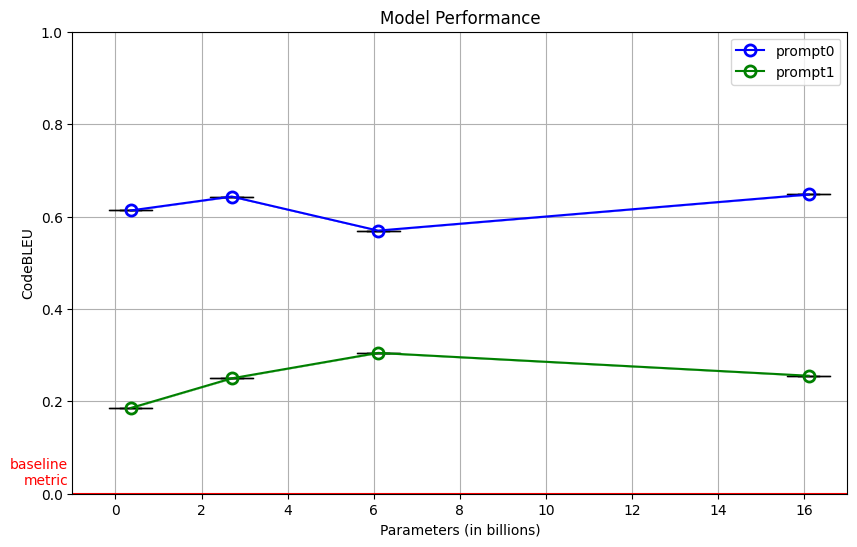

In [15]:
bugs2fix_renderer_codebleu = OutputRenderer(
    baseline=codebleu_baseline,
    metric="CodeBLEU",
)

bugs2fix_renderer_codebleu.render(ys=codebleu_metrics)